# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

In [2]:
#general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import LabelEncoder

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm

## Data loading

In [3]:
# Data loading functions. Uncomment the one you want to use
import pandas as pd
from worcliver.load_data import load_data

data = load_data()


### Dividing our data into test-, training- and validation-set

The dataset should be randomly divided into :
* training datasets = 70 % of samples
* test datasets = 20 % of samples
* validation datasets = 10 % of samples

In [4]:
amount_in_training = round(len(data.index)*0.8)
amount_in_test = round(len(data.index)*0.2)

#split the data into training+validation data and test data
training_data, test_data = model_selection.train_test_split(data, test_size=(amount_in_test) / len(data), random_state=42)
#random_state is set to a fixed value (in this case 42, which is an onofficial standard in machine learning), which ensures 
#that the same random division is made every time this code is ran.
# --> to ensure that this is reproducible

#checking the lengths
print(f'Training + validation: {len(training_data)} samples, Test: {len(test_data)} samples.')
print(f'So total number of samples: {len(training_data)+len(test_data)}')

Training + validation: 149 samples, Test: 37 samples.
So total number of samples: 186


### Data inspection

In [5]:
print(f'The number of samples: {len(training_data.index)}')
print(f'The number of columns: {len(training_data.columns)}')

training_data_df = pd.DataFrame(training_data)
#print(data_df.head())
print(training_data_df.info())
#print(data_df.describe())
cat_cols = training_data_df.select_dtypes(include=["object"]).columns
num_cols = training_data_df.select_dtypes(include=["number"]).columns
print(f"categorical columns: {len(cat_cols)}")
print(f'numerical columns: {len(num_cols)}')

no_variation_samples = 0
for sample in training_data.index:
    data_sample = training_data.drop(columns=['label'])
    if data_sample.loc[sample].max() == data_sample.loc[sample].min():
        no_variation_samples += 1
no_variation_col = 0
for feature in training_data.columns:
    if training_data[feature].max() == training_data[feature].min():
        no_variation_col += 1
print(f'samples with no variation: {no_variation_samples}')
print(f'columns with no variation: {no_variation_col}')

label = training_data[['label']]
malignant_count = (label == "malignant").sum()
benign_count = (label == "benign").sum()

print(f'Class Distribution: malignant {malignant_count} and benign {benign_count}')

The number of samples: 149
The number of columns: 494
<class 'pandas.core.frame.DataFrame'>
Index: 149 entries, Liver-030_0 to Liver-103_0
Columns: 494 entries, label to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25), object(1)
memory usage: 576.2+ KB
None
categorical columns: 1
numerical columns: 493
samples with no variation: 0
columns with no variation: 19
Class Distribution: malignant label    76
dtype: int64 and benign label    73
dtype: int64


### Extracting the label per patient

This label (benign/malignant) is the ground truth per patient.

In [6]:
label_training = training_data[['label']]
training_data.drop(columns=['label'], inplace=True)

label_training_binary = label_training.copy()
label_training_binary['label'] = label_training_binary['label'].map({'malignant': 1, 'benign': 0})


### Finding the missing data

Checking whether the missing data is stored as NaN or 0, finding the columns in which missing data is found as well as the empty features.


In [7]:
#making a dataframe
data_training = pd.DataFrame(training_data)

#checking whether missing data is stored as NaN
nan_check = data_training.isna()

#conclusion: missing data is not stored as NaN

#checking whether missing data is stored as 0
zero_counts = (data_training == 0).sum()

#conclusion: missing data is stored as 0; however is this true? values in Radiomics can also be calculated as being 0, so how do you know if 0 is the
#intended value, or a missing value? you can't, so do not consider the zeros as missing data.

zero_counts_columns = zero_counts[zero_counts > 0]
print(f'The number of features in which there is missing data: {zero_counts_columns.count()}')
print(f'The number of missing data is: {sum(zero_counts_columns)}')

The number of features in which there is missing data: 29
The number of missing data is: 3488


### Handling the missing data

The missing data was handled as follows:
1. Deleting the empty features from the data
2. Replacing the missing data with the median value

In [8]:
#step 1: deleting the empty features from the data
#a feature is empty when it contains values for <30% of the samples
#   empty_features = the features that are considered empty
#   missing_data_features = the features that contain missing data
empty_features = []
missing_data_features = []

# for feature, missing_data in zero_counts_columns.items():  
#     if missing_data > 0.7*len(data_training.index):
#         empty_features.append(feature)
#     else:
#         missing_data_features.append(feature)
#         print(f'The amount of data missing in {feature} is {missing_data}')

data_training_clean = data_training.drop(columns=empty_features)

print(f'Empty features: {len(empty_features)}, Features with missing data: {len(missing_data_features)}.')

Empty features: 0, Features with missing data: 0.


In [9]:
#step 2: replacing the missing data with the median
# for feature in missing_data_features:
#     data_training_clean[feature].replace(0, np.nan, inplace=True)
    
#     # Vervang de NaN waarden door de mediaan
#     median_value = data_training_clean[feature].median()
#     data_training_clean[feature].fillna(median_value, inplace=True)
check_zero_counts = (data_training_clean == 0).sum()
check_zero_counts_columns = check_zero_counts[check_zero_counts > 0]
print(f'To check: the number of features in which there is missing data is now: {check_zero_counts_columns.count()}')

To check: the number of features in which there is missing data is now: 29


### Pre-processing: standardization/normalization

First is tested whether the data is normally distributed or not with the Shapiro-Wilk Test. 
* p-value > 0.05: the data is likely normally distributed
* p-value < 0.05: the data is likely not normally distributed

In [10]:
shapiro_results = {}
no_variation = 0
features_no_variation = []

for feature in data_training_clean.columns:
    if data_training_clean[feature].max() == data_training_clean[feature].min():
        shapiro_results[feature] = None  #skipping the feature when there is no variation
        no_variation += 1
        features_no_variation.append(feature)
    else:
        #Shapiro-Wilk test to check for normality
        stat, p_value = stats.shapiro(data_training_clean[feature])

        #if normally distributed, store 1, else store 0
        if p_value > 0.05:
            result = 1
        else:
            result = 0

        shapiro_results[feature] = result

#the number of normally distributed features
print(f'The number of features that do not have variation in their values is: {no_variation}')
print(f'The number of normally distributed features is: {sum(1 for result in shapiro_results.values() if result == 1)}')
print(f'The number of not normally distributed features is: {sum(1 for result in shapiro_results.values() if result == 0)}')

#deleting the features in which there was no variation
data_training_clean = data_training_clean.drop(columns=features_no_variation)



The number of features that do not have variation in their values is: 19
The number of normally distributed features is: 48
The number of not normally distributed features is: 426


#### Standardization

In [11]:
#code from workgroup; sklearn package has a function that standardizes the data, so this is applied here:
scaler = preprocessing.StandardScaler()
data_training_standardized = scaler.fit_transform(data_training_clean)

### Normalization

In [12]:
min_max_scaler = preprocessing.MinMaxScaler()
data_training_normalized = min_max_scaler.fit_transform(data_training_standardized)
data_training_normalized_df = pd.DataFrame(data_training_normalized, columns=data_training_clean.columns)
print (f' size of data training is: {data_training_standardized.shape}')

 size of data training is: (149, 474)


### Correlation

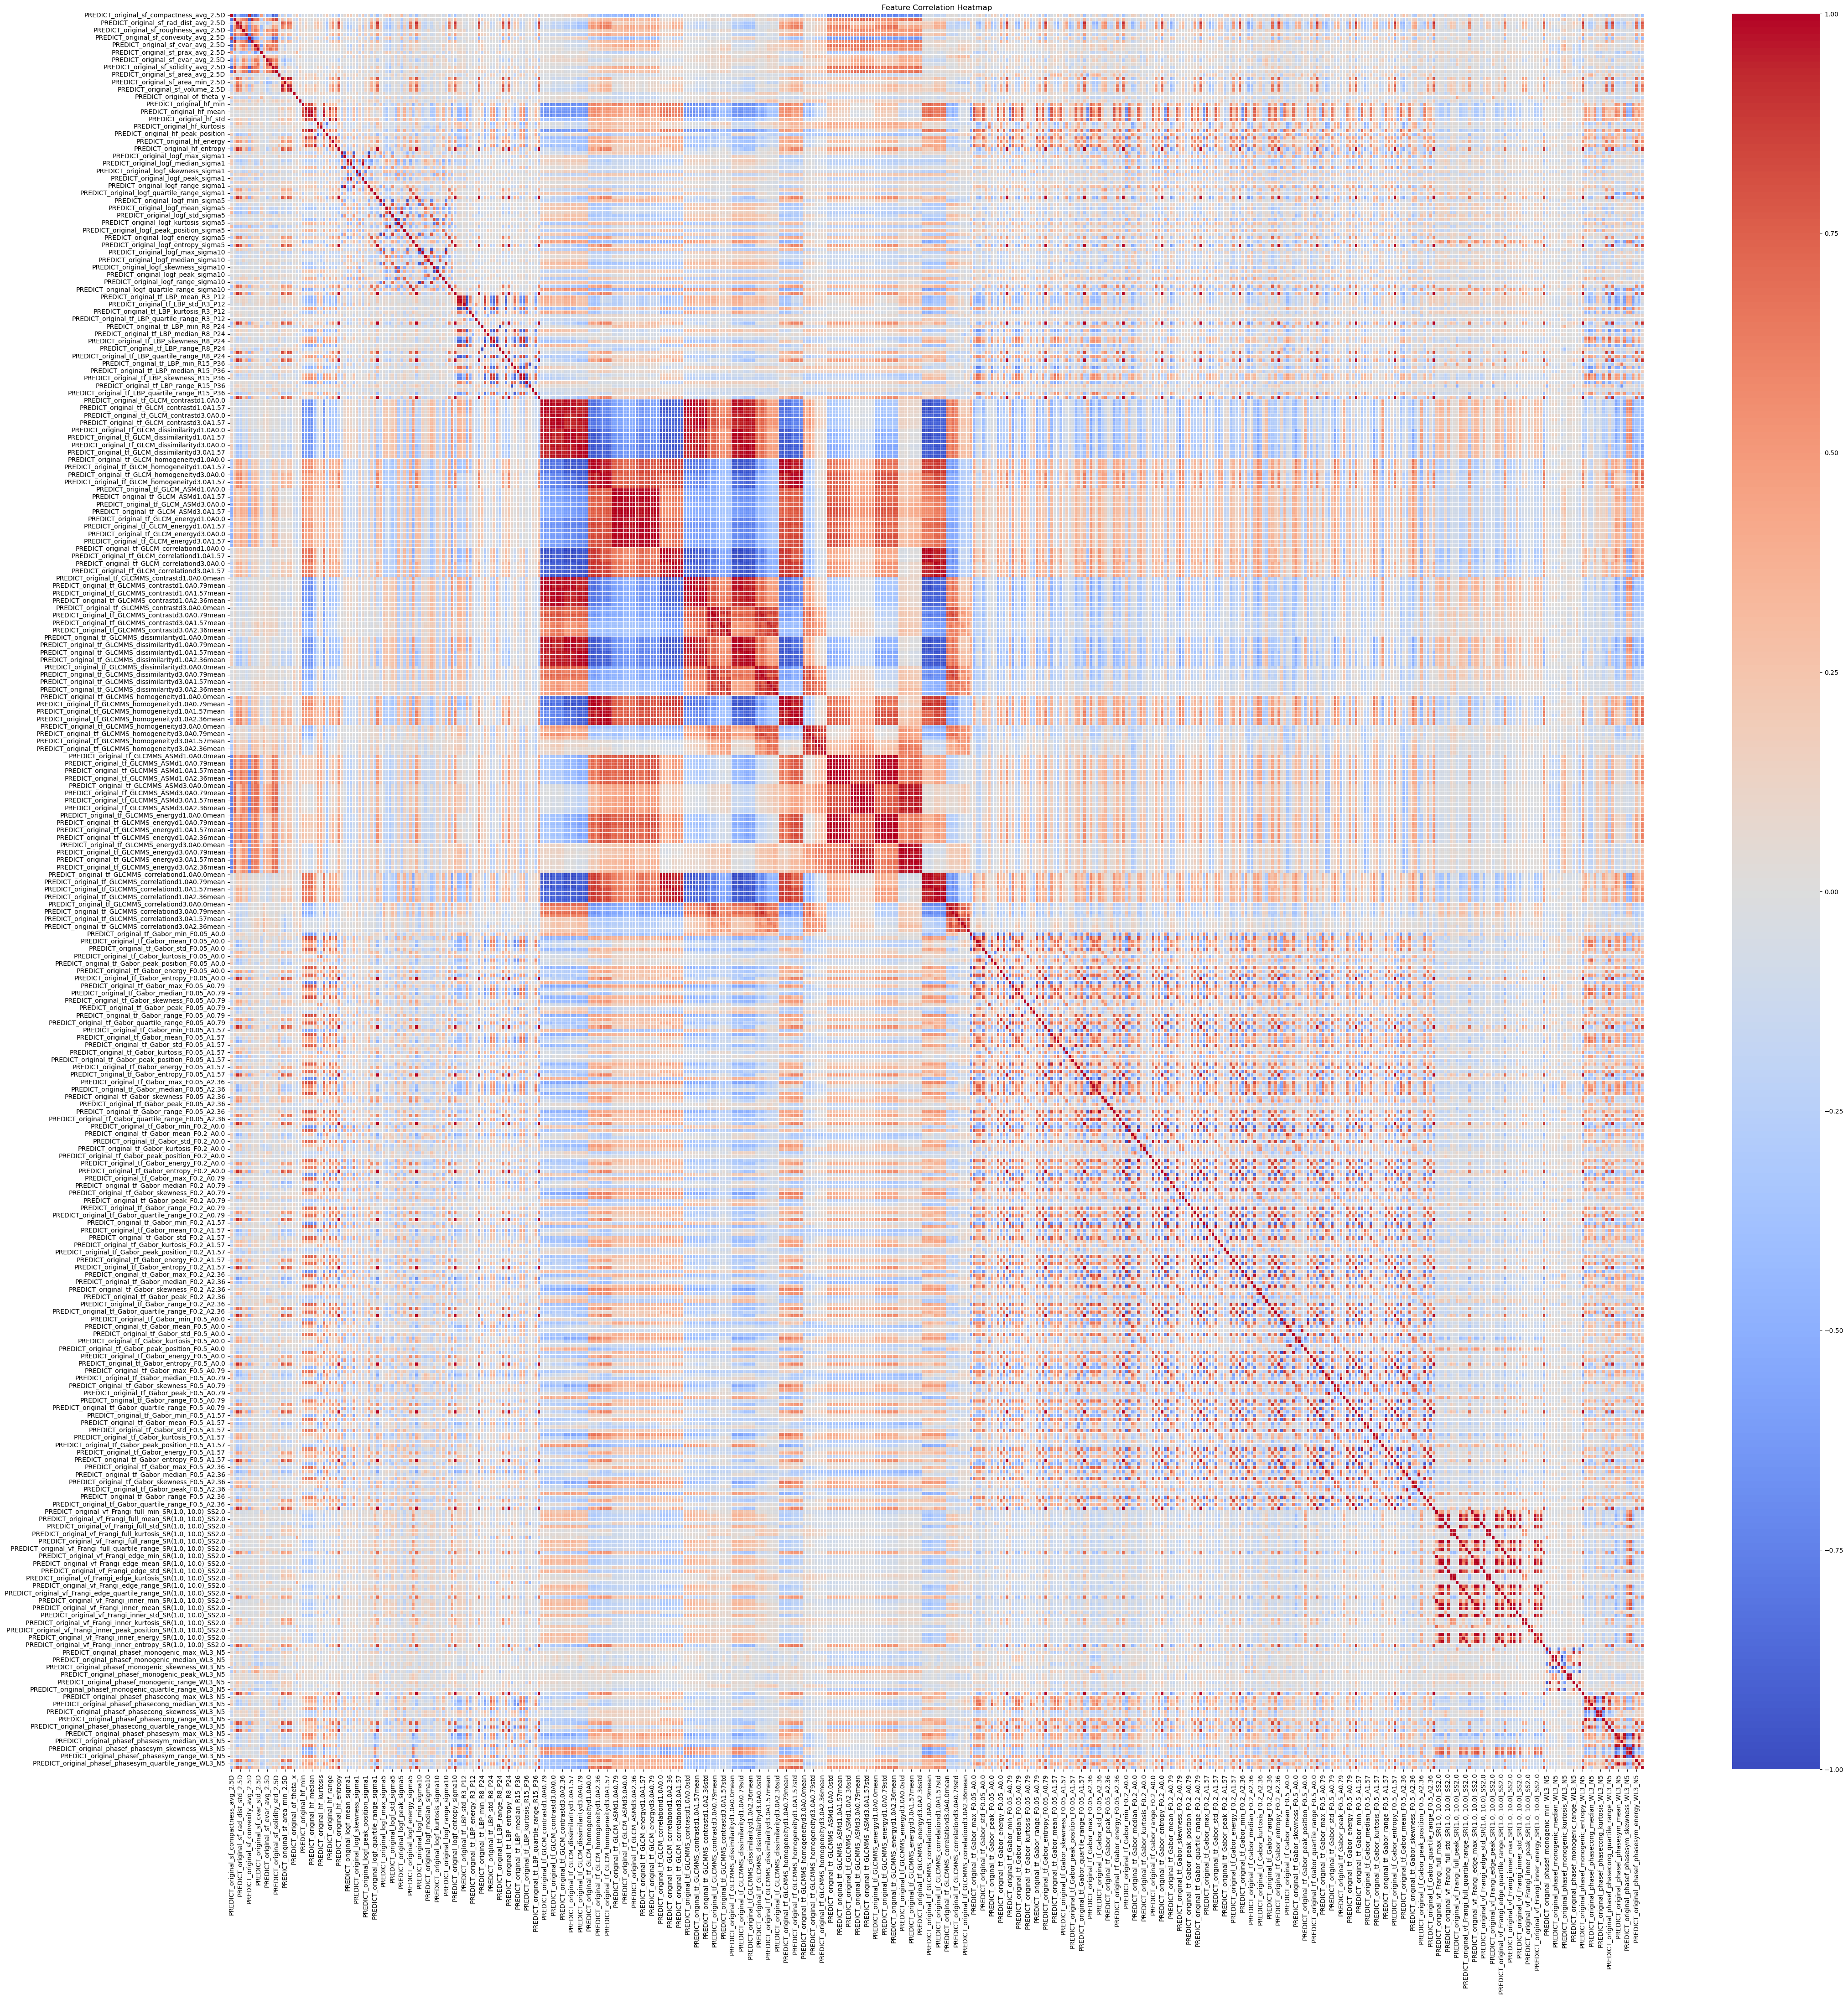

In [13]:
corr_matrix = data_training_normalized_df.corr()

plt.figure(figsize=(50, 50))
seaborn.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### Feature selection

Univariate feature selection with Pearson correlation

In [14]:
#step 1: calculate the correlation and associated p-value for every feature-pair
corr_matrix = pd.DataFrame(index=data_training_normalized_df.columns, columns=data_training_normalized_df.columns, dtype=float)
pval_matrix = pd.DataFrame(index=data_training_normalized_df.columns, columns=data_training_normalized_df.columns, dtype=float)

for col1 in data_training_normalized_df.columns:
    for col2 in data_training_normalized_df.columns:
        if col1 == col2:
            corr_matrix.loc[col1, col2] = 1.0
            pval_matrix.loc[col1, col2] = 0.0
        else:
            r, p = stats.pearsonr(data_training_normalized_df[col1], data_training_normalized_df[col2])
            corr_matrix.loc[col1, col2] = r
            pval_matrix.loc[col1, col2] = p


#step 2: loop through all the feature pairs and determine which ones have a high correlation and low p-value
threshold = 0.9
p_threshold = 0.05

to_drop = set()

for i, col1 in enumerate(data_training_normalized_df.columns):
    for j, col2 in enumerate(data_training_normalized_df.columns):
        if i >= j:
            continue
        r = corr_matrix.loc[col1, col2]
        p = pval_matrix.loc[col1, col2]

        if abs(r) > threshold and p < p_threshold:
            if col1 not in to_drop and col2 not in to_drop:
                col_to_drop = col2
                to_drop.add(col_to_drop)

print("Dropped features due to high correlation:")
print(to_drop)

#step 3: drop one of the features in a feature pair with high correlation and low p-value
data_training_reduced = data_training_normalized_df.drop(columns=to_drop)

print(f"Size of new training data set is:{data_training_reduced.shape}; Old was: {data_training_normalized_df.shape}")


Dropped features due to high correlation:
{'PREDICT_original_tf_GLCM_contrastd3.0A1.57', 'PREDICT_original_tf_GLCMMS_correlationd1.0A0.0std', 'PREDICT_original_tf_GLCMMS_contrastd1.0A2.36std', 'PREDICT_original_tf_GLCM_homogeneityd1.0A2.36', 'PREDICT_original_logf_peak_sigma1', 'PREDICT_original_tf_Gabor_range_F0.05_A0.0', 'PREDICT_original_tf_GLCM_ASMd3.0A0.79', 'PREDICT_original_phasef_phasecong_range_WL3_N5', 'PREDICT_original_tf_Gabor_entropy_F0.2_A0.79', 'PREDICT_original_tf_Gabor_range_F0.5_A0.79', 'PREDICT_original_tf_GLCMMS_correlationd1.0A1.57mean', 'PREDICT_original_tf_GLCM_contrastd1.0A1.57', 'PREDICT_original_tf_GLCMMS_dissimilarityd3.0A0.0std', 'PREDICT_original_tf_Gabor_peak_F0.5_A0.79', 'PREDICT_original_tf_LBP_range_R8_P24', 'PREDICT_original_tf_LBP_skewness_R3_P12', 'PREDICT_original_phasef_monogenic_entropy_WL3_N5', 'PREDICT_original_tf_Gabor_peak_F0.5_A1.57', 'PREDICT_original_tf_GLCMMS_ASMd3.0A2.36std', 'PREDICT_original_tf_Gabor_std_F0.05_A0.79', 'PREDICT_original_

LASSO feature selection 

--> nu hier gecodeerd op dat hij doorgaat op de univariate feature selection!

In [15]:
label_training_array = label_training_binary.values.flatten()

#step 1: perform Lasso with cross-validation for 50 values of alpha on 10 segments over 10.000 iterations
lasso_cv = LassoCV(alphas=np.logspace(-4, 0, 100), cv=10, max_iter=10000)  
lasso_cv.fit(data_training_reduced, label_training_array)

#step 2: find the best alpha value
best_alpha = lasso_cv.alpha_
print(f"Optimal Alpha: {best_alpha}")

#step 3: fit LASSO again with optimal alpha
lasso_opt = Lasso(alpha=best_alpha)
lasso_opt.fit(data_training_reduced, label_training_array)

#step 4: get the features of interest, and only extract those
selected_features = data_training_reduced.columns[lasso_opt.coef_ != 0]
print(f"Number of selected features: {len(selected_features)}")
print(f"Final Selected Features: {list(selected_features)} ")

training_data_selected = data_training_reduced[selected_features]
training_data_selected_df = pd.DataFrame(training_data_selected)

print(f"Size of new training data set is:{training_data_selected.shape}")


Optimal Alpha: 0.004977023564332114
Number of selected features: 37
Final Selected Features: ['PREDICT_original_sf_prax_avg_2.5D', 'PREDICT_original_sf_area_min_2.5D', 'PREDICT_original_of_theta_z', 'PREDICT_original_logf_mean_sigma1', 'PREDICT_original_logf_median_sigma1', 'PREDICT_original_logf_kurtosis_sigma1', 'PREDICT_original_logf_quartile_range_sigma1', 'PREDICT_original_logf_min_sigma5', 'PREDICT_original_logf_std_sigma5', 'PREDICT_original_logf_median_sigma10', 'PREDICT_original_logf_peak_position_sigma10', 'PREDICT_original_tf_LBP_std_R3_P12', 'PREDICT_original_tf_LBP_mean_R8_P24', 'PREDICT_original_tf_GLCMMS_contrastd3.0A0.0mean', 'PREDICT_original_tf_GLCMMS_homogeneityd3.0A2.36mean', 'PREDICT_original_tf_GLCMMS_ASMd3.0A0.0mean', 'PREDICT_original_tf_GLCMMS_correlationd3.0A1.57std', 'PREDICT_original_tf_GLCMMS_correlationd3.0A2.36mean', 'PREDICT_original_tf_Gabor_peak_position_F0.05_A0.0', 'PREDICT_original_tf_Gabor_min_F0.05_A2.36', 'PREDICT_original_tf_Gabor_peak_F0.05_A2.

### Random Forest classifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [16]:
label_training_array = label_training_binary.values.flatten()
#input_random_forest = data_training_normalized_df.values
input_random_forest = training_data_selected_df
from sklearn.ensemble import RandomForestClassifier

X_train = input_random_forest
y_train = label_training_array

param_grid = {
    'n_estimators': [110, 115, 120],                     #trees
    'max_depth': [5, 8, 13],                         #maximum depth
    'bootstrap': [True],                     #bootstrap on or off >> moet dus True of False zijn, maar aangezien er altijd True kwam dat nu even gelaten voor snelheid runnen
    'min_samples_split': [2, 3, 4, 5],                    #minimum samples required to split
    'min_samples_leaf': [1, 2, 3],                  #minimum samples wat je uiteindelijk in een leaf overhoudt 
    'max_features': ['sqrt', 'log2'],                       #controls the number of features selected, can also try log2 
    'min_impurity_decrease': [0.00001, 0.000005, 0.00002]   #controls the minimum amount of impurity reduction required for a split to be created    
}

random_forest = RandomForestClassifier(random_state=42)
n = 0
best_model = None
best_hyperparams = None
highest_accuracy = 0
rf_accuracies = []

n += 1

#de grid search naar de beste hyperparameters
grid_search = model_selection.GridSearchCV(random_forest, param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
#grid_search = RandomizedSearchCV(random_forest, param_grid, cv=10, scoring='accuracy', n_iter=20, n_jobs=-1, random_state=42, verbose=1)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best Hyperparameters, fold {n}:", grid_search.best_params_)

best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

#find the accuracies per fold
results_df = pd.DataFrame(grid_search.cv_results_)

# Vind alle individuele fold score kolommen
fold_columns = [col for col in results_df.columns if col.startswith("split") and col.endswith("_test_score")]

# Aantal folds
n_folds = len(fold_columns)

# Functie om CI te berekenen per rij
def compute_confidence_interval(row):
    scores = row[fold_columns].values
    mean = np.mean(scores)
    std = np.std(scores, ddof=1)  # sample std dev
    ci_halfwidth = stats.norm.ppf(0.975) * std / np.sqrt(n_folds)
    return pd.Series({
        'mean_score': mean,
        'std_score': std,
        'ci_lower': mean - ci_halfwidth,
        'ci_upper': mean + ci_halfwidth
    })

# Pas toe op elke rij (elke modelconfiguratie)
ci_df = results_df.apply(compute_confidence_interval, axis=1)

# Combineer met de parameterinstellingen
final_df = pd.concat([results_df['params'], ci_df], axis=1)

# Print de top 5 met hoogste mean_score
top_models = final_df.sort_values(by='mean_score', ascending=False).head(5)
print(top_models)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


KeyboardInterrupt: 

In [24]:
print(fold_columns)

['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score']


### Support Vector Machine

In [46]:
from sklearn import model_selection
from sklearn.svm import SVC
label_training_array = label_training_binary.values.flatten()
#input_SVM = data_training_normalized_df.values
input_SVM = training_data_selected_df.values

outer_cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=None)

param_grid = {
    'kernel': ['poly', 'rbf'],                  # add more kernels
    'C': [0.01, 0.5, 1, 10, 100],               # Expand the range of C values
    'gamma': ['scale', 'auto', 0.01, 0.1, 0.5], # Add more gamma values
    'degree': [1, 3, 5, 10],                    # Add more degree values for polynomial kernel
    'coef0': [0.01, 0.5, 1, 2]                  # Extend coef0 range
}

SVM = SVC()
n=0
for train_idx, validate_idx in outer_cv.split(input_SVM, label_training_array):
    X_train_SVM, X_validate_SVM = input_SVM[train_idx], input_SVM[validate_idx]
    y_train_SVM, y_validate_SVM = label_training_array[train_idx], label_training_array[validate_idx]
    
    n += 1

    #de grid search naar de beste hyperparameters
    grid_search = model_selection.GridSearchCV(SVM, param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)

    # Fit GridSearchCV to the data
    grid_search.fit(X_train_SVM, y_train_SVM)

    # Print the best parameters
    print(f"Best Hyperparameters, fold {n}:", grid_search.best_params_)

    best_params = grid_search.best_params_
    best_svm = grid_search.best_estimator_

    accuracy_2 = best_svm.score(X_validate_SVM, y_validate_SVM)
    rf_accuracies.append(accuracy_2)

    #checking of dit de hoogste accuracy tot nu toe is, ja dan replace, nee dan skip
    if accuracy_2 > highest_accuracy:
        highest_accuracy = accuracy_2
        best_model = best_svm
        best_hyperparams = best_params

    print(f"Accuracy Validation set, fold {n}: {accuracy_2:.2f}")

print("\nBest performing model found:")
print(f"Highest Validation Accuracy: {highest_accuracy:.2f}")
print(f"Best Hyperparameters: {best_hyperparams}")


Fitting 10 folds for each of 800 candidates, totalling 8000 fits
Best Hyperparameters, fold 1: {'C': 1, 'coef0': 0.01, 'degree': 1, 'gamma': 0.5, 'kernel': 'poly'}
Accuracy Validation set, fold 1: 0.83
Fitting 10 folds for each of 800 candidates, totalling 8000 fits
Best Hyperparameters, fold 2: {'C': 0.5, 'coef0': 0.01, 'degree': 1, 'gamma': 0.5, 'kernel': 'poly'}
Accuracy Validation set, fold 2: 0.87
Fitting 10 folds for each of 800 candidates, totalling 8000 fits
Best Hyperparameters, fold 3: {'C': 100, 'coef0': 0.5, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
Accuracy Validation set, fold 3: 0.80
Fitting 10 folds for each of 800 candidates, totalling 8000 fits
Best Hyperparameters, fold 4: {'C': 10, 'coef0': 1, 'degree': 10, 'gamma': 0.01, 'kernel': 'poly'}
Accuracy Validation set, fold 4: 0.70
Fitting 10 folds for each of 800 candidates, totalling 8000 fits
Best Hyperparameters, fold 5: {'C': 0.5, 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Accuracy Validation s

### K-Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

label_training_array = label_training_binary.values.flatten()
input_knn = training_data_selected_df.values
y = label_training_array

# Define parameter grid for number of neighbors
param_grid = {
    'n_neighbors': list(range(1, 31)) ,
    'weights': ['uniform', 'distance'],
 }   
    
# Initialize the classifier
knn = KNeighborsClassifier()

# Define 10-fold stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# GridSearchCV to find the best k
grid_search = GridSearchCV(
    knn,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True 
)

# Fit model
grid_search.fit(input_knn, y)

# Output results
print("Best number of neighbors:", grid_search.best_params_['n_neighbors'])
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

# Convert cv_results_ to a DataFrame for easier manipulation
results_df = pd.DataFrame(grid_search.cv_results_)

# Sort by mean test score in descending order
sorted_results = results_df.sort_values(by="mean_test_score", ascending=False)

# Vind alle individuele fold score kolommen
fold_columns = [col for col in results_df.columns if col.startswith("split") and col.endswith("_test_score")]

# Aantal folds
n_folds = len(fold_columns)

# Functie om CI te berekenen per rij
def compute_confidence_interval(row):
    scores = row[fold_columns].values
    mean = np.mean(scores)
    std = np.std(scores, ddof=1)  # sample std dev
    ci_halfwidth = stats.norm.ppf(0.975) * std / np.sqrt(n_folds)
    return pd.Series({
        'mean_score': mean,
        'std_score': std,
        'ci_lower': mean - ci_halfwidth,
        'ci_upper': mean + ci_halfwidth
    })

# Pas toe op elke rij (elke modelconfiguratie)
ci_df = results_df.apply(compute_confidence_interval, axis=1)

# Combineer met de parameterinstellingen
final_df = pd.concat([results_df['params'], ci_df], axis=1)

# Print de top 5 met hoogste mean_score
top_models = final_df.sort_values(by='mean_score', ascending=False).head(5)
print(top_models)


Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best number of neighbors: 21
Best cross-validation accuracy: 0.84
                                        params  mean_score  std_score  \
41  {'n_neighbors': 21, 'weights': 'distance'}    0.839524   0.154288   
37  {'n_neighbors': 19, 'weights': 'distance'}    0.832857   0.157590   
40   {'n_neighbors': 21, 'weights': 'uniform'}    0.832857   0.147891   
36   {'n_neighbors': 19, 'weights': 'uniform'}    0.826190   0.151007   
38   {'n_neighbors': 20, 'weights': 'uniform'}    0.812857   0.165324   

    ci_lower  ci_upper  
41  0.743897  0.935151  
37  0.735183  0.930531  
40  0.741195  0.924519  
36  0.732597  0.919784  
38  0.710390  0.915324  


### Plot optimal numbers of neighbors

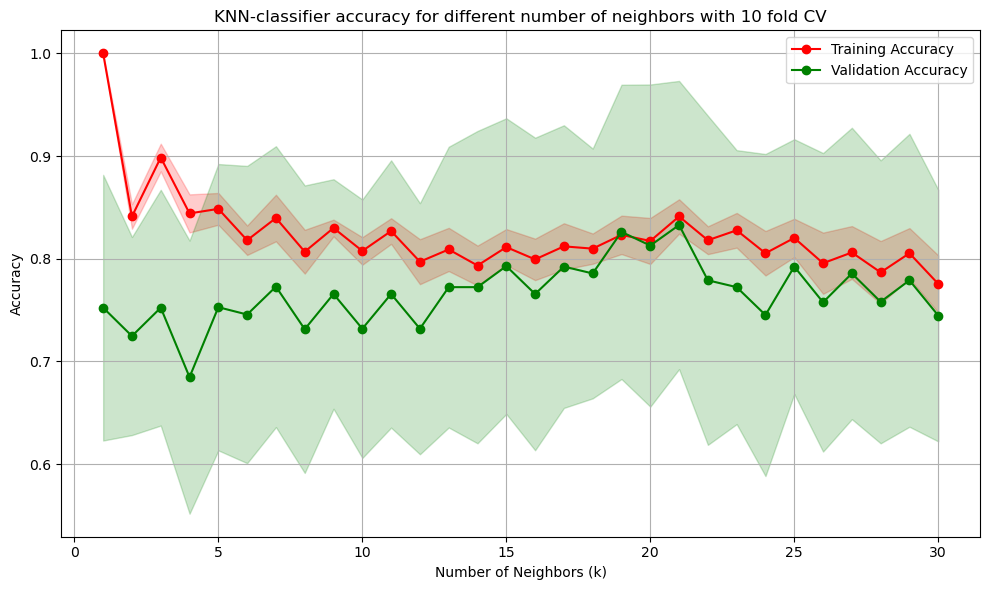

In [62]:
import matplotlib.pyplot as plt

# Filter for one weight type if needed (optional)
final_df = results_df[results_df['param_weights'] == 'uniform'].copy()

# Extract k values
final_df['n_neighbors'] = final_df['param_n_neighbors']

# Sort by number of neighbors
final_df = final_df.sort_values(by='n_neighbors')

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot mean training accuracy
ax.plot(final_df['n_neighbors'], final_df['mean_train_score'], label='Training Accuracy', color='red', marker='o')
ax.fill_between(final_df['n_neighbors'],
                final_df['mean_train_score'] - final_df['std_train_score'],
                final_df['mean_train_score'] + final_df['std_train_score'],
                color='red', alpha=0.2)

# Plot mean validation accuracy
ax.plot(final_df['n_neighbors'], final_df['mean_test_score'], label='Validation Accuracy', color='green', marker='o')
ax.fill_between(final_df['n_neighbors'],
                final_df['mean_test_score'] - final_df['std_test_score'],
                final_df['mean_test_score'] + final_df['std_test_score'],
                color='green', alpha=0.2)

# Formatting
ax.set_xlabel("Number of Neighbors (k)")
ax.set_ylabel("Accuracy")
ax.set_title("KNN-classifier accuracy for different number of neighbors with 10 fold CV")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


### Learning Curve

In [1]:
# Initalize dataset
X, y = #insert feature vector X and labels y of own dataset
classifier = #make use of classifier chosen from hyperparameter estimation

SyntaxError: invalid syntax (4036493374.py, line 2)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

#create a learning curve based on training and testdata. To get an estimate of the scores uncertainty you can use a
#cross-validation procedure

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)  # ensures that you display the learning curve of two classifiers next to each other

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate(#only if we have multiple classifiers):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}"))

SyntaxError: '(' was never closed (2282472012.py, line 23)